# Quickstart: Amortized Posterior Estimation

## Table of Contents

TBD

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np

# ensure the backend is set
import os
if "KERAS_BACKEND" not in os.environ:
    # set this to "torch", "tensorflow", or "jax"
    os.environ["KERAS_BACKEND"] = "tensorflow"

import keras

# for BayesFlow devs: this ensures that the latest dev version can be found
import sys
sys.path.append('../')

import bayesflow as bf

Welcome to the very first tutorial on using BayesFlow for amortized posterior estimation! In this notebook, we will estimate the means of a multivariate Gaussian model and illustrate some features of the library along the way.

Here is a brief description of amortized posterior estimation:

In traditional posterior estimation, as in Bayesian inference, we seek to compute or approximate the posterior distribution of model parameters given observed data for each new data instance separately. This process can be computationally expensive, especially for complex models or large datasets, because it often involves iterative optimization or sampling methods. This step needs to be repeated for each new instance of data.

Amortized posterior estimation offers a solution to this problem. “Amortization” here refers to spreading out the computational cost over multiple instances. Instead of computing a new posterior from scratch for each data instance, amortized inference learns a function. This function is parameterized by a neural network, that directly maps observations to an approximation of the posterior distribution. This function is trained over the dataset to approximate the posterior for any new data instance efficiently. In this example, we will use a simple Gaussian model to illustrate the basic concepts of amortized posterior estimation.

Above, we have already imported the core entities that we will need for this notebook. In brief:

* The module `simulator` contains high-level wrappers for gluing together priors, simulators, and meta-functions, and generating all quantities of interest for a modeling scenario.
* The module `adapters` contains utilities that preprocess the generated data from the simulator to a format more friendly for the neural approximators.
* The module `networks` contains the core neural architecture used for various tasks, e.g., a `FlowMatching` architecture for realizing normalizing flows, or a `DeepSet` for learning permutation-invariant summary representations (embeddings).
* The module `appoximators` contains high-level wrappers which connect the various networks together and instruct them about their particular goals in the inference pipeline.

The nuts and bolts of using BayesFlow for Bayesian parameter estimation have already been described in the corresponding papers:

* TBD
* TBD
* TBD

At a high level, our architecture consists of a summary network $\mathbf{h}$
and an inference network $\mathbf{f}$
which jointly amortize a generative model. The summary network transforms input data $\mathbf{x}$
of potentially variable size to a fixed-length representations. The inference network generates random draws from an approximate posterior $\mathbf{q}$
via a conditional invertible neural network (cINN). This process is illustrated in the figure below:

## Defining the Generative Model

From the perspective of the BayesFlow framework, a generative model is more than just a prior (encoding beliefs about the parameters before observing data) and a simulator (a likelihood function, often implicit, that generates data given parameters). In addition, it consists of various implicit context assumptions, which we can make explicit at any time. Furthermore, we can also amortize over these context variables, thus making our real-world inference more flexible (i.e., applicable to more contexts). We are leveraging the concept of amortized inference and extending it to context variables as well. The figure below illustrates the skeleton of a generative model as conceptualized in the BayesFlow framework.

This conceptual model allows you to tackle very flexible model families with BayesFlow, as well as various other Bayesian tasks, such as prior sensitivity analysis or multiverse analysis.

Prior sensitivity analysis: it is a technique used in Bayesian statistics to assess how sensitive the results of a model are to the choice of the prior distribution. In Bayesian inference, the prior represents our existing knowledge or assumptions about the parameters before observing the data. However, the selection of an appropriate prior can sometimes be subjective, and different priors can lead to different posterior estimates. Prior sensitivity analysis involves systematically varying the priors and examining how these variations affect the posterior estimates.

The toy Gaussian model we will use for this tutorial takes a particularly simple form:

\begin{align}
    \mathbf{\mu} &\sim \mathcal{N}_D(\mathbf{0}, \sigma_0 \mathbb{I}),\\
    \mathbf{x}_n &\sim \mathcal{N}_D(\mathbf{\mu}, \sigma_1 \mathbb{I}) \quad \text{for } n = 1, ..., N,
\end{align}

where $\mathcal{N}_D$
denotes a multivariate Gaussian (normal) density with $D$
dimensions, which we set at $D = 4$
for the current example. For simplicity, we will also set $\sigma_0 = 1$
and $\sigma_1 = 1$
. We will now implement this model using the latest numpy interface.

## Prior

First, we define the prior for a single draw.

In [3]:
def theta_prior():
    theta = np.random.normal(size=4)
    return dict(theta=theta)

## Forward Simulator

Next, we use the sampled prior to generate data through the likelihood function with $N$ observations.

In [4]:
def forward_model(theta, n_obs=50):
    x = np.random.normal(loc=theta, size=(n_obs, theta.shape[0]))
    return dict(x=x)

After that, we bundle the prior and the likelihood functions together as a single simulator. We do so by using BayesFlow's `simulator` module, more specifically the `make_simulator` which is a type of sequential simulator that takes on lambda functions.

In [5]:
simulator = bf.make_simulator([theta_prior, forward_model])

In [9]:
samples = simulator.sample((1000,))
print(samples['theta'].shape)
print(samples['x'].shape)

(1000, 4)
(1000, 50, 4)


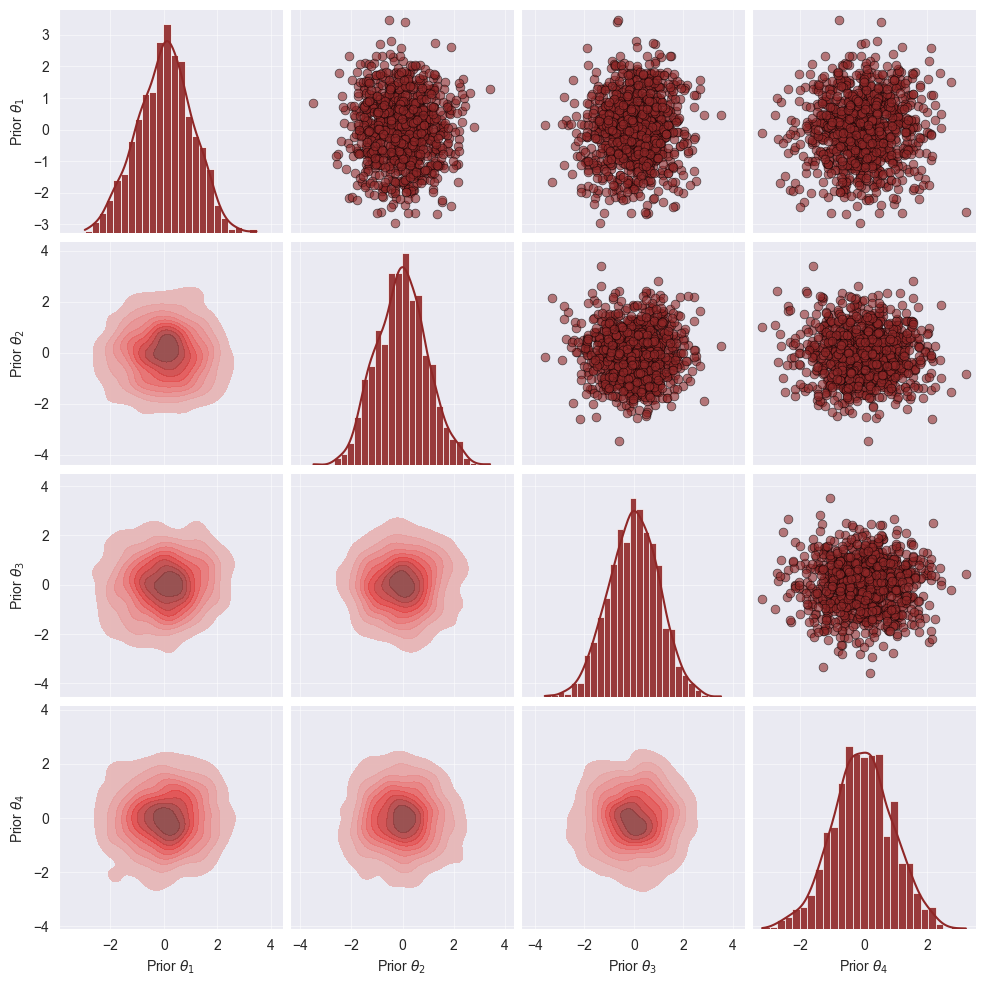

In [10]:
f = bf.diagnostics.plot_distribution_2d(samples['theta'], context="Prior")